# 线性回归从零开始

在了解了线性回归的背景知识之后，现在我们可以动手实现了。
尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用NDArray和autograd来实现一个线性回归的训练

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示

In [62]:
%matplotlib inline

from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random


## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000,输入个数为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$ ，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$ ,以及一个随机噪声项 $\epsilon$ 来生成标签
$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$

其中噪声项服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [63]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale = 1, shape = (num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape = labels.shape)

In [49]:
features


[[ 0.5925345  -0.7567092 ]
 [ 0.13926521 -0.20225924]
 [ 1.0466251  -2.3175972 ]
 ...
 [-0.91519624 -1.2238808 ]
 [-1.6869311  -0.46909225]
 [-0.06433223 -0.06503782]]
<NDArray 1000x2 @cpu(0)>

In [50]:
labels.shape

(1000,)

注意，features 的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量

In [51]:
features[0], labels[0]

(
 [ 0.5925345 -0.7567092]
 <NDArray 2 @cpu(0)>, 
 [7.960054]
 <NDArray 1 @cpu(0)>)

通过生成第二个特征features[:, 1] 和标签labels的散点图，可以更直观地观察两者间的线性关系

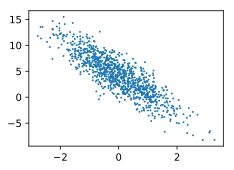

In [64]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1); # 加分号只显示图



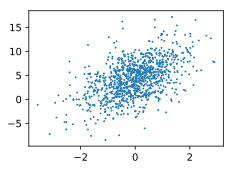

In [53]:
set_figsize()
plt.scatter(features[:,0].asnumpy(), labels.asnumpy(), 1);

我们将上面的plt作图函数以及use_svg_display函数 和set_figsize函数定义在d2lzh包里。以后在作图时，我们将直接调用d2lzh.plt。由于plt在d2lzh包中是一个全局变量，我们在作图前只需要调用d2lzh.set_figsize()即可打印矢量图并设置图的尺寸

## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本，这里我们定义一个函数：它每次返回batch_size个随机样本的特征和标签

In [65]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j) # take函数根据索引返回对应元素

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2),分别对应批量大小和输入个数，标签形状为批量大小。

In [66]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-3.4611495  -0.6770074 ]
 [-0.2855195   0.95305073]
 [-1.1455961   1.0392694 ]
 [-0.3829253   0.24097896]
 [-0.40644124  0.72610015]
 [-0.26498938  0.78306395]
 [-1.6418129  -1.1940751 ]
 [-0.57964253  1.1455241 ]
 [ 1.3704672  -0.0473682 ]
 [-0.9667835  -0.06738201]]
<NDArray 10x2 @cpu(0)> 
[-0.41291884  0.39742708 -1.6219846   2.6126845   0.9239919   1.0058647
  4.9814568  -0.853903    7.104424    2.5018287 ]
<NDArray 10 @cpu(0)>


## 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0

In [67]:
w = nd.random.normal(scale = 0.01, shape = (num_inputs, 1))
b = nd.zeros(shape=(1,))

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建他们的梯度

In [68]:
w.attach_grad()
b.attach_grad()

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用dot函数做矩阵乘法


In [69]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

## 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数，在实现中，我们需要把真实值y变形成预测值y_hat得形状，一下函数返回的结果也将和y_hat的形状相同

In [70]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2/2

## 定义优化算法

以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数，这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值

In [71]:
def sgd(params, lr, batch_size): # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 训练模型

在训练中， 我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本，通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10,每个小批量的损失l的形状为(10, 1).由于l并不是一个标量，运行l.backward()将对l中元素求和得到新的变量，再求该变量有关模型参数的梯度

在一个迭代周期中，我们将完整便利一遍data_iter函数，并对训练数据集中所有样本都使用一次。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都是需要通过反复试错来不断调节。虽然迭代周期数设的越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面"优化算法"一章中详细介绍。

In [72]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    # 训练模型一共需要num_epochs个迭代
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次(假设样本数能够被批量大小整除)。
    # X 和 y 分别是小批量样本的特征和标签
    for X, y  in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y) # l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
        
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1,train_l.mean().asnumpy()))


epoch 1, loss 0.038059
epoch 2, loss 0.000135
epoch 3, loss 0.000045
epoch 4, loss 0.000045
epoch 5, loss 0.000045


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。 它们应该很接近。

In [21]:
true_w, w

([2, -3.4], 
 [[ 1.9997963]
  [-3.3993444]]
 <NDArray 2x1 @cpu(0)>)

In [22]:
true_b,b

(4.2, 
 [4.1995344]
 <NDArray 1 @cpu(0)>)